In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [5]:
# Load metadata and features.
tracks = pd.read_csv('data/fma_metadata/tracks_processed_filled.csv')
#genres = pd.read_csv('data/fma_metadata/genres.csv')
#features = pd.read_csv('data/fma_metadata/features.csv')
#echonest = pd.read_csv('data/fma_metadata/echonest.csv')

tracks.shape#, genres.shape, features.shape, echonest.shape

(106486, 43)

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score 

In [7]:
class_name = 'Attribution-NonCommercial-ShareAlike 3.0 International'

attributes = [col for col in tracks.columns if col != class_name]

X = tracks[attributes].values
y = tracks[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [11]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.988324046829024
F1-score [0.99322914 0.95762808]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27368
           1       1.00      0.92      0.96      4578

    accuracy                           0.99     31946
   macro avg       0.99      0.96      0.98     31946
weighted avg       0.99      0.99      0.99     31946



In [12]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.986905234298907,
  'recall': 0.9996346097632272,
  'f1-score': 0.9932291383034726,
  'support': 27368},
 '1': {'precision': 0.9976331360946745,
  'recall': 0.9207077326343381,
  'f1-score': 0.9576280813359082,
  'support': 4578},
 'accuracy': 0.988324046829024,
 'macro avg': {'precision': 0.9922691851967907,
  'recall': 0.9601711711987826,
  'f1-score': 0.9754286098196904,
  'support': 31946},
 'weighted avg': {'precision': 0.9884425890356823,
  'recall': 0.988324046829024,
  'f1-score': 0.9881273528280606,
  'support': 31946}}

In [13]:
import json
json.dumps(classification_report(y_test, y_pred, output_dict=True))

'{"0": {"precision": 0.986905234298907, "recall": 0.9996346097632272, "f1-score": 0.9932291383034726, "support": 27368}, "1": {"precision": 0.9976331360946745, "recall": 0.9207077326343381, "f1-score": 0.9576280813359082, "support": 4578}, "accuracy": 0.988324046829024, "macro avg": {"precision": 0.9922691851967907, "recall": 0.9601711711987826, "f1-score": 0.9754286098196904, "support": 31946}, "weighted avg": {"precision": 0.9884425890356823, "recall": 0.988324046829024, "f1-score": 0.9881273528280606, "support": 31946}}'

In [14]:
json.loads(json.dumps(classification_report(y_test, y_pred, output_dict=True)))

{'0': {'precision': 0.986905234298907,
  'recall': 0.9996346097632272,
  'f1-score': 0.9932291383034726,
  'support': 27368},
 '1': {'precision': 0.9976331360946745,
  'recall': 0.9207077326343381,
  'f1-score': 0.9576280813359082,
  'support': 4578},
 'accuracy': 0.988324046829024,
 'macro avg': {'precision': 0.9922691851967907,
  'recall': 0.9601711711987826,
  'f1-score': 0.9754286098196904,
  'support': 31946},
 'weighted avg': {'precision': 0.9884425890356823,
  'recall': 0.988324046829024,
  'f1-score': 0.9881273528280606,
  'support': 31946}}

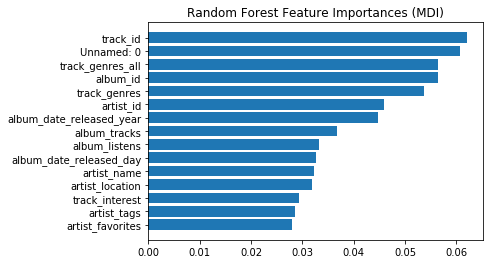

In [17]:
nbr_features = 15
feature_names = attributes

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(feature_names)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [18]:
from sklearn.inspection import permutation_importance

In [19]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

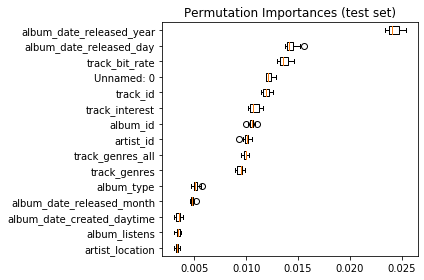

In [20]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [21]:
import pydotplus
from sklearn import tree
from IPython.display import Image

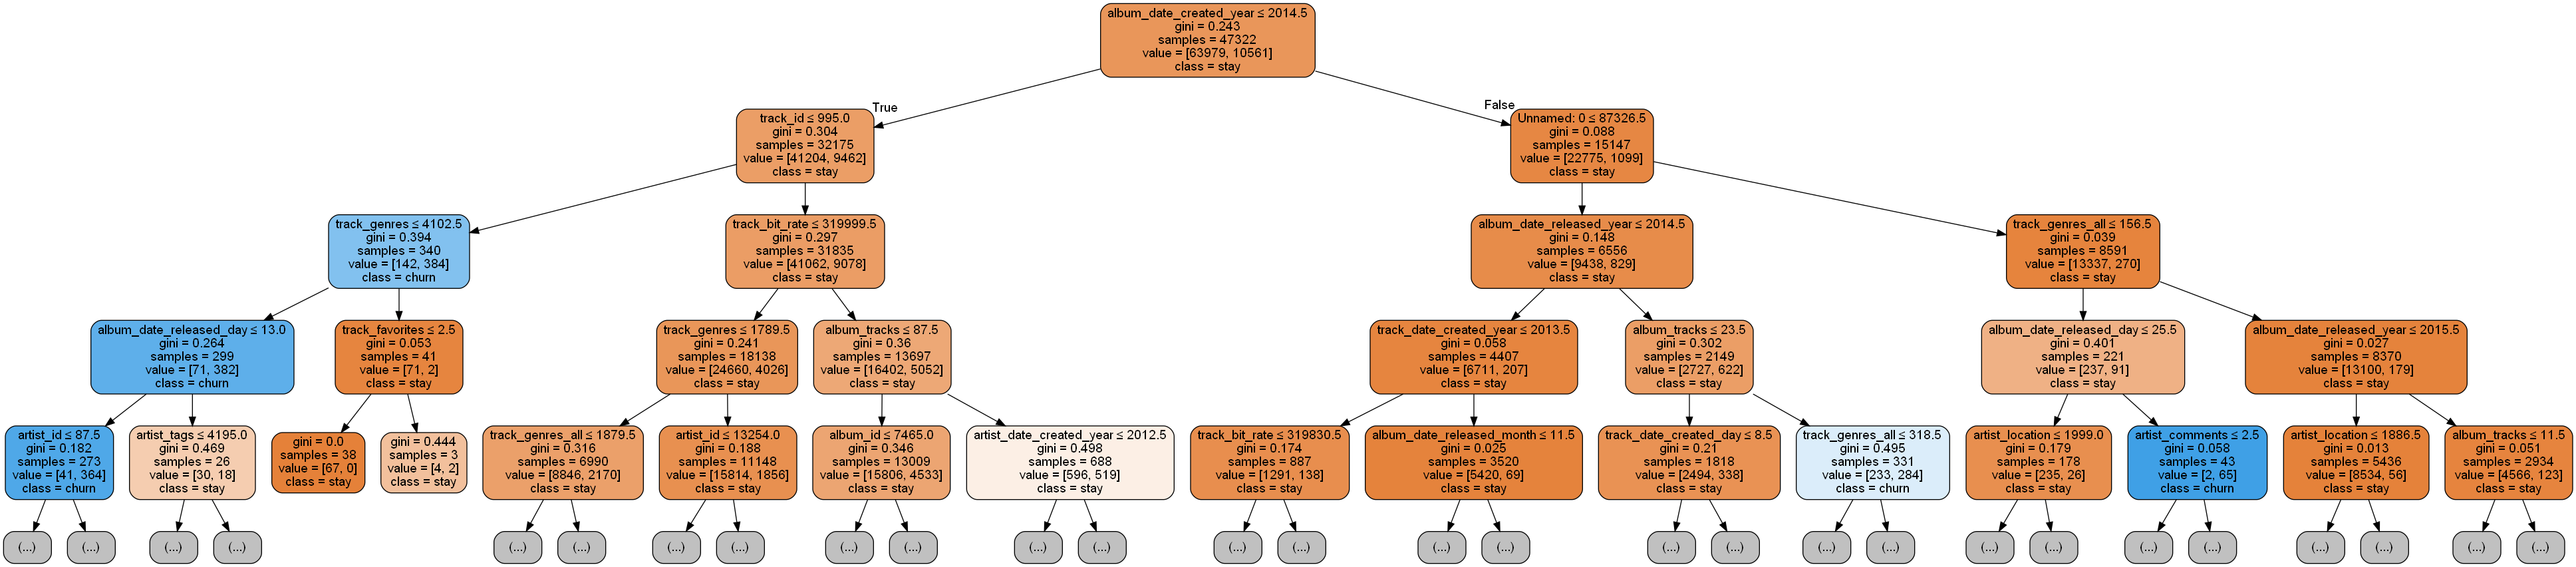

In [22]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['stay', 'churn'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

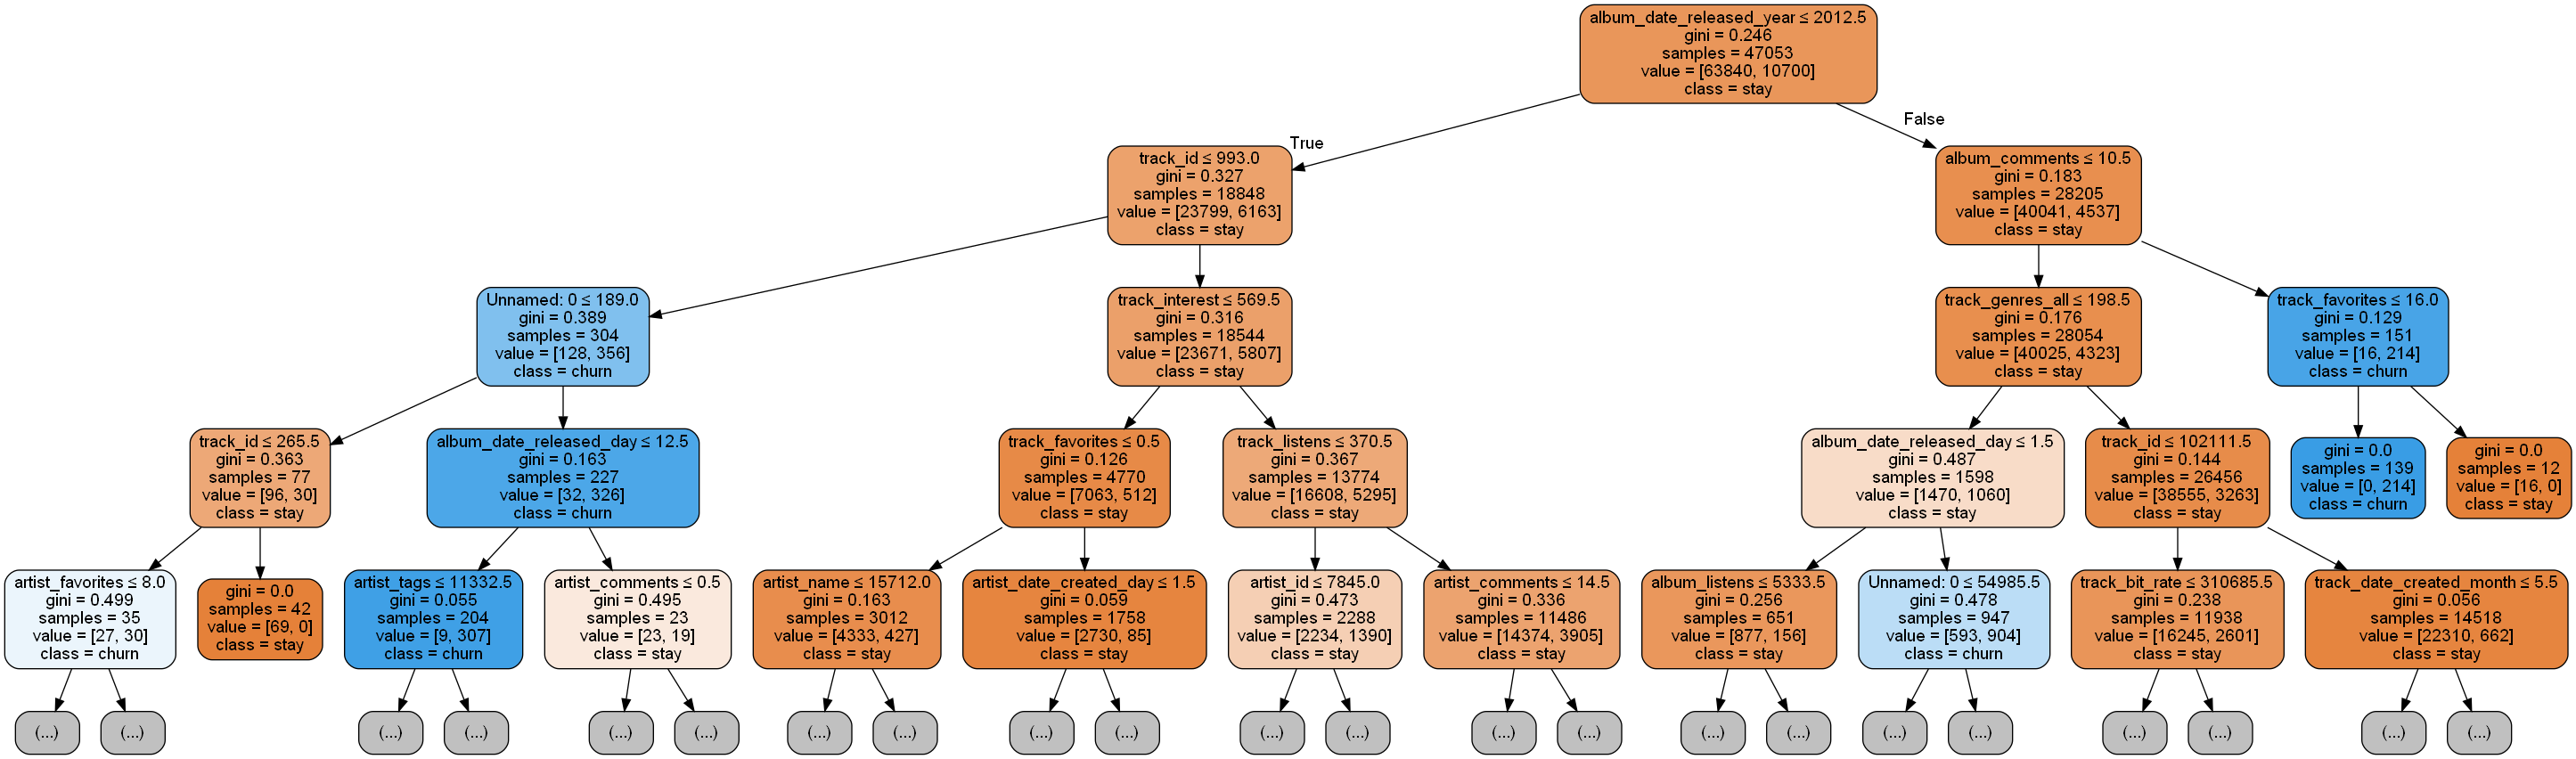

In [23]:
dot_data = tree.export_graphviz(clf.estimators_[1], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['stay', 'churn'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [24]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=4, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.992142991297815
F1-score [0.99543313 0.97189564]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27368
           1       1.00      0.95      0.97      4578

    accuracy                           0.99     31946
   macro avg       0.99      0.97      0.98     31946
weighted avg       0.99      0.99      0.99     31946



In [25]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9927064421210793
F1-score [0.9957594  0.97395775]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27368
           1       1.00      0.95      0.97      4578

    accuracy                           0.99     31946
   macro avg       0.99      0.98      0.98     31946
weighted avg       0.99      0.99      0.99     31946



In [26]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8658674012395918
F1-score [0.92737411 0.12390104]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     27368
           1       0.97      0.07      0.12      4578

    accuracy                           0.87     31946
   macro avg       0.92      0.53      0.53     31946
weighted avg       0.88      0.87      0.81     31946



In [27]:
from sklearn.model_selection import cross_val_score

In [28]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.989 +/- 0.001


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [30]:
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1,3,5,7,9],
             }

grid_search = GridSearchCV(clf, param_grid=param_list, cv=5)
grid_search.fit(X_train, y_train)
random_search = RandomizedSearchCV(clf, param_distributions=param_list, cv=5)
random_search.fit(X_train, y_train)

clf = grid_search.best_estimator_

y_pred = clf.predict(X_test)


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9924873223564765
F1-score [0.99563223 0.97316637]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27368
           1       1.00      0.95      0.97      4578

    accuracy                           0.99     31946
   macro avg       0.99      0.98      0.98     31946
weighted avg       0.99      0.99      0.99     31946



In [31]:
grid_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'min_samples_leaf': 1, 'min_samples_split': 20}

In [32]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10],
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9794966505978839
F1-score [0.9881707  0.92313109]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27368
           1       1.00      0.86      0.92      4578

    accuracy                           0.98     31946
   macro avg       0.99      0.93      0.96     31946
weighted avg       0.98      0.98      0.98     31946



In [33]:
random_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3}

In [34]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [35]:
clf = BaggingClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9900770049458462
F1-score [0.99423416 0.96443397]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27368
           1       0.99      0.94      0.96      4578

    accuracy                           0.99     31946
   macro avg       0.99      0.97      0.98     31946
weighted avg       0.99      0.99      0.99     31946



In [ ]:
clf = BaggingClassifier(base_estimator=SVC(C=1000), n_estimators=10, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca
X=X_train_pca

In [ ]:
# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles



# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 1
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min()-1 , X[:, 0].max()+1 
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step/100))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [ ]:
X

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [('rf',RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)),
                             ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))]
clf = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

estimators = [('rf',RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)),
                             ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))]
clf = StackingClassifier( estimators=estimators, final_estimator=MLPClassifier(random_state=0,solver= 'adam', learning_rate_init= 0.01, hidden_layer_sizes=(15)))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))